In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dask import dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
sns.set_theme(style="whitegrid")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/helsinki-city-bikes/database.csv


In [2]:
ddf = dd.read_csv('../input/helsinki-city-bikes/database.csv',dtype={'departure_id': 'str','return_id': 'str'},low_memory=True)

In [3]:
ddf = ddf.rename(columns={'distance (m)': 'distance',
                                     'duration (sec.)': 'duration',
                                     'avg_speed (km/h)':'speed',
                                      'Air temperature (degC)':'temperature',
                                     })
pd.set_option('display.float_format', lambda x: '%.3f' % x)
ddf[["distance", "duration", "temperature"]].describe().compute()

,distance,duration,temperature
count,12157458.000,12157458.000,12141556.000
mean,2295.275,959.775,15.650
std,24520.672,7346.528,5.498
min,-4292467.000,0.000,-5.200
25%,1245.000,434.000,13.800
50%,2209.000,745.000,17.900
75%,3639.000,1184.000,21.000
max,3681399.000,5401659.000,32.900


In [4]:
ddf = ddf[ (50 < ddf['distance']) & (ddf['distance'] < 10000) &
                    (120 < ddf['duration']) & (ddf['duration'] <  18000) &
                    (-20 < ddf['temperature']) & (ddf['temperature'] < 50)        
                    ]

ddf[["distance", "duration", "temperature"]].describe().compute()

,distance,duration,temperature
count,11278850.000,11278850.000,11278850.000
mean,2242.385,783.600,15.637
std,1494.708,795.838,5.495
min,51.000,121.000,-5.200
25%,1413.000,463.000,13.800
50%,2245.000,752.000,17.900
75%,3714.000,1188.000,21.000
max,9999.000,17998.000,32.900


In [5]:
ddf = ddf.reset_index(drop=True).compute()
ddf['departure']=pd.to_datetime(ddf['departure'], format='%Y-%m-%d %H:%M:%S')
ddf['day']=ddf['departure'].dt.day_name()

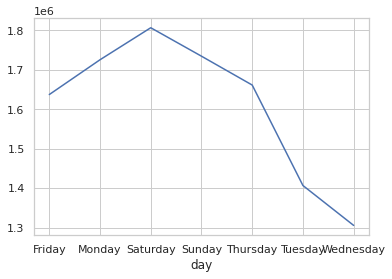

In [6]:
trips_by_day = ddf.groupby(by='day')['departure'].count()
dictDay = {'Monday':trips_by_day['Monday'],'Tuesday':trips_by_day['Tuesday'],'Wednesday':trips_by_day['Wednesday'],
          'Thursday':trips_by_day['Thursday'],'Friday':trips_by_day['Friday'],'Saturday':trips_by_day['Saturday'],
          'Sunday':trips_by_day['Sunday']}
sns.lineplot(y=dictDay.values(),x=trips_by_day.keys())
plt.show()

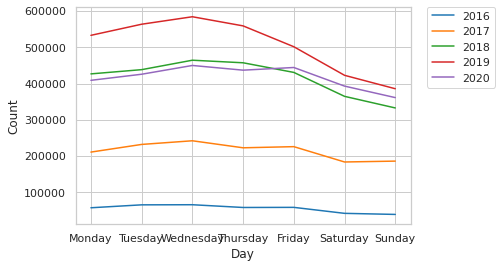

In [7]:
ddf['year']=ddf['departure'].dt.year
trips_by_year_day=ddf.groupby(['year','day'])['departure'].count()

dfYearDay=pd.DataFrame(columns=['Day','Count','Year'])
def convert_to_df(year):
    dictYearDay = {'Monday':trips_by_year_day[year]['Monday'],'Tuesday':trips_by_year_day[year]['Tuesday'],'Wednesday':trips_by_year_day[year]['Wednesday'],
          'Thursday':trips_by_year_day[year]['Thursday'],'Friday':trips_by_year_day[year]['Friday'],'Saturday':trips_by_year_day[year]['Saturday'],
          'Sunday':trips_by_year_day[year]['Sunday']}
    df = pd.DataFrame(dictYearDay.values(),index=dictYearDay.keys()).reset_index()
    df.columns = ['Day','Count']
    df['Year']= year
    return df

for x in [2016,2017,2018,2019,2020]:
    df=convert_to_df(x)
    dfYearDay=pd.concat([dfYearDay,df],ignore_index=True)
dfYearDay['Count']=dfYearDay['Count'].astype('int')
dfYearDay['Year']=dfYearDay['Year'].astype('int')

sns.lineplot(data=dfYearDay,x='Day',y='Count',hue='Year',palette='tab10')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

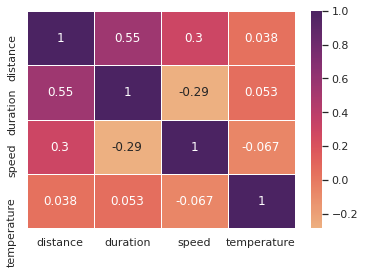

In [8]:
corrMatrix=ddf[['distance','duration','speed','temperature']].corr()
sns.heatmap(data=corrMatrix,linewidths=0.5,annot=True,cmap='flare')
plt.show()

In [9]:
ddf['dHour'] = ddf['departure'].dt.hour
def create_time_range(hour):
    if  0 <= hour < 3:
        return '[0-3)'
    elif  3 <= hour < 6:
        return '[3-6)'
    elif  6 <= hour < 9:
        return '[6-9)'
    elif  9 <= hour < 12:
        return '[9-12)'
    elif  12 <= hour < 15:
        return '[12-15)'
    elif  15 <= hour < 18:
        return '[15-18)'
    elif  18 <= hour < 21:
        return '[18-21)'
    elif  21 <= hour <= 23:
        return '[21-23]'
ddf['Time Range'] = ddf['dHour'].apply(create_time_range)

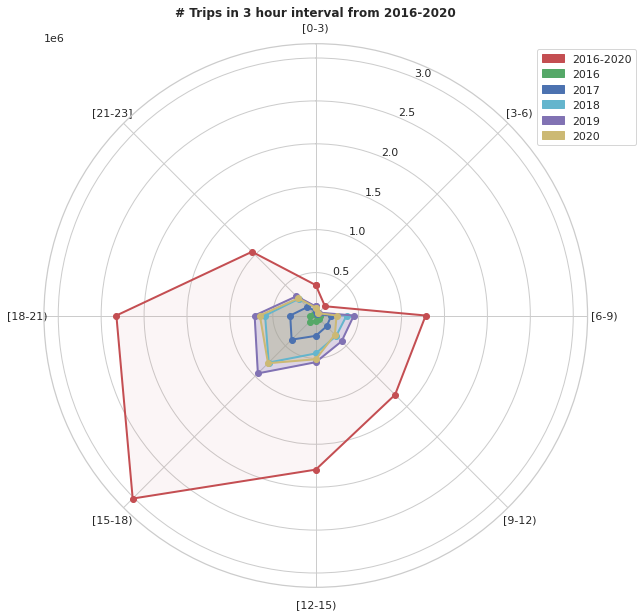

In [10]:
plt.figure(figsize=(10,10))

def filter_by_year(year):
    if year != 'all':
         df = ddf[ddf['year']==year]
    else:
        df = ddf
    count_by_time_range = df.groupby('Time Range')['departure'].count()
    count_by_time_range=count_by_time_range.reset_index(drop=False)
    count_by_time_range['Time Range'] = count_by_time_range['Time Range'].astype('str')
    count_by_time_range['sortby']=count_by_time_range['Time Range'].str.replace('-',' ').str.slice(start=1,stop=3).astype('int')
    count_by_time_range=count_by_time_range.sort_values(by='sortby')
    count_by_time_range = count_by_time_range.rename(columns={'departure':'Count'})
    return count_by_time_range

years=[['all',2016,2017],[2018,2019,2020]]
labels=[['2016-2020','2016','2017'],['2018','2019','2020']]
colors=[['r','g','b'],['c','m','y']]

def plot_by_year():
    alpha=[[0.05,0.1,0.15],[0.2,0.25,0.3]]
    ax = plt.subplot(111, polar=True)
    for i in range(2):
        for j in range(3):
            count_by_time_range=filter_by_year(years[i][j])
            labels=count_by_time_range['Time Range']
            stats=count_by_time_range['Count']
            angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
            stats=np.concatenate((stats,[stats[0]]))
            angles=np.concatenate((angles,[angles[0]]))
            ax.plot(angles, stats, 'o-', linewidth=2,color=colors[i][j],label=labels[i][j])
            ax.fill(angles, stats, alpha=alpha[i][j],color=colors[i][j])
            ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
            ax.set_theta_offset(np.pi/2)
            ax.set_theta_direction(-1)
            ax.grid(True)
    ax.set_title('# Trips in 3 hour interval from 2016-2020',weight='bold')      
plot_by_year()

handles = []
for i in range(2):
    for j in range(3):
        handles.append(mpatches.Patch(color=colors[i][j], label=labels[i][j]))
plt.legend(loc='upper right',handles=handles,bbox_to_anchor=(1.1,1))
plt.show()

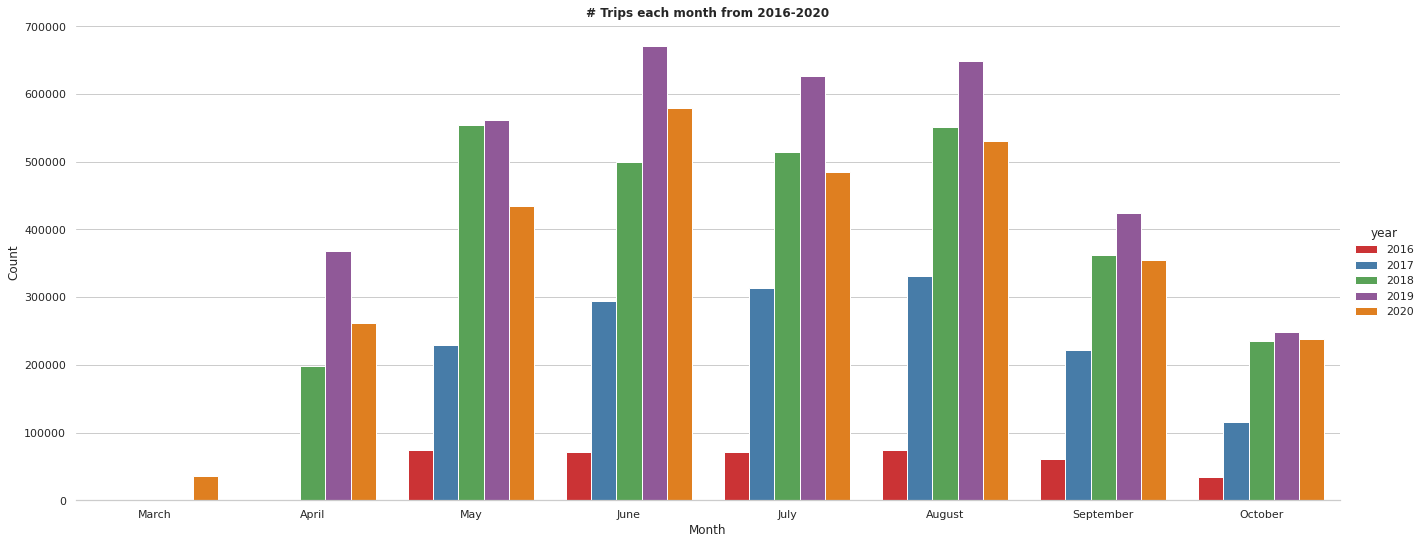

In [11]:
ddf['month']=ddf['departure'].dt.month
count_by_year_month=ddf.groupby(['year','month'])['departure'].count()
count_by_year_month=count_by_year_month.reset_index()
count_by_year_month=count_by_year_month.sort_values(by=['year','month'])
g = sns.catplot(
    data=count_by_year_month, kind="bar",
    x="month", y="departure", hue="year",
    ci="sd", palette="Set1", height=7.27, aspect=18.7/7.27)

g.despine(left=True)
g.set_xticklabels(['March','April','May','June','July','August','September','October'])
g.set_axis_labels("Month", "Count")
plt.title('# Trips each month from 2016-2020',weight='bold')
plt.show()

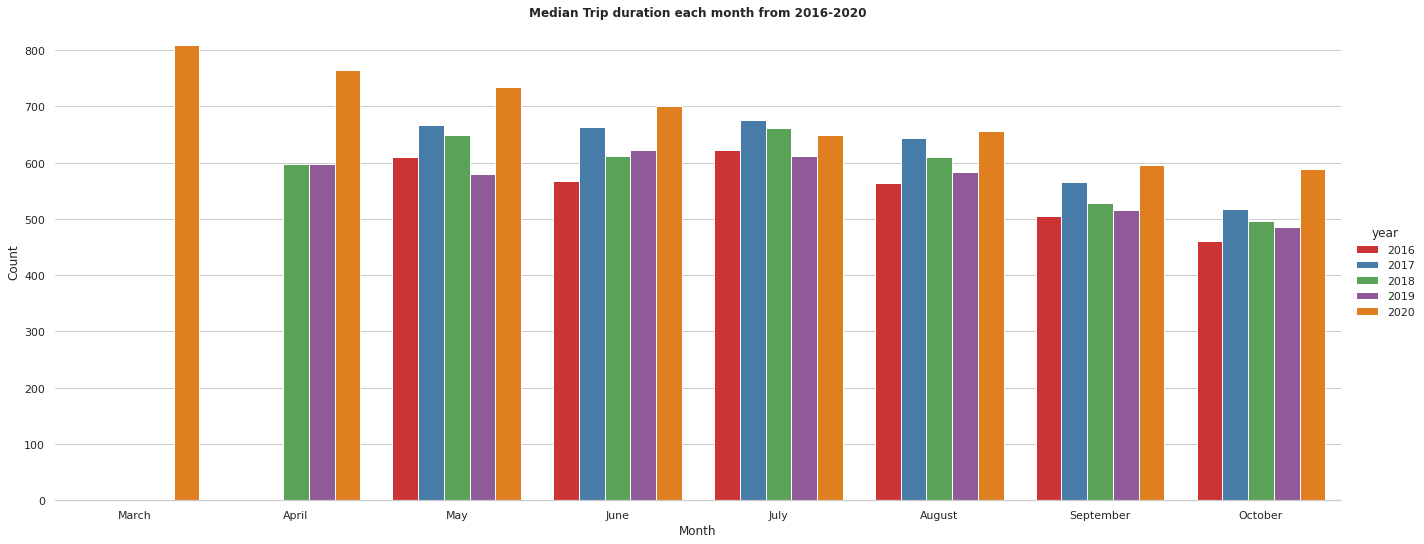

In [12]:
count_by_year_month=ddf.groupby(['year','month'])['duration'].median()
count_by_year_month=count_by_year_month.reset_index()
count_by_year_month=count_by_year_month.sort_values(by=['year','month'])

sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=count_by_year_month, kind="bar",
    x="month", y="duration", hue="year",
    ci="sd", palette="Set1", height=7.27, aspect=18.7/7.27)

g.despine(left=True)
g.set_xticklabels(['March','April','May','June','July','August','September','October'])
g.set_axis_labels("Month", "Count")
plt.title('Median Trip duration each month from 2016-2020',weight='bold')
plt.show()

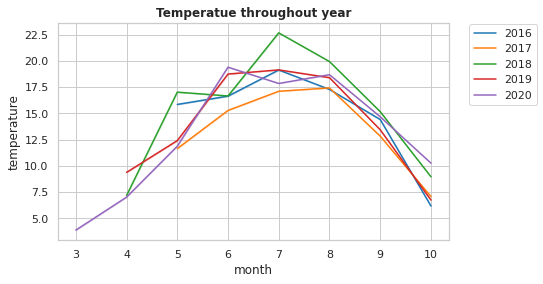

In [13]:
plt.figure(figsize=(7,4))
sns.lineplot(data=ddf,x='month',y='temperature',hue='year',palette='tab10')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.1)
plt.title('Temperatue throughout year',weight='bold')
plt.show()